## Bolus Glucose Control in Type 1 Diabetes Using Deep Reinforcement Learning
Raphael Joost, 18-???-??? & Yanis Schärer, 18-114-058

### Implementing a Deep Deterministic Policy Gradient (DDPG) agent


In [1]:
import numpy as np
import torch as th
import torch.nn.functional as F
from copy import deepcopy
from datetime import datetime
import simglucose
import gym
from gym.wrappers import FlattenObservation

C:\Users\yanis\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define Replay Buffer
class ReplayBuffer:
    def __init__(self, state_dim, action_dim, device, max_size=500):
        self.device = device
        self.max_size = max_size
        self.size = 0
        self.ptr = 0
        self.state_buffer = np.zeros((max_size, state_dim))
        self.action_buffer = np.zeros((max_size, action_dim))
        self.next_state_buffer = np.zeros((max_size, state_dim))
        self.reward_buffer = np.zeros((max_size, 1))
        self.done_buffer = np.zeros((max_size, 1))

    def store(self, state, action, reward, next_state, done):
        self.state_buffer[self.ptr] = state
        self.action_buffer[self.ptr] = action
        self.next_state_buffer[self.ptr] = next_state
        self.reward_buffer[self.ptr] = reward
        self.done_buffer[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size):
        idx = np.random.randint(0, self.size, size=batch_size)
        return (
            th.tensor(self.state_buffer[idx], dtype=th.float32).to(self.device),
            th.tensor(self.action_buffer[idx], dtype=th.float32).to(self.device),
            th.tensor(self.reward_buffer[idx], dtype=th.float32).to(self.device),
            th.tensor(self.next_state_buffer[idx], dtype=th.float32).to(self.device),
            th.tensor(self.done_buffer[idx], dtype=th.float32).to(self.device)
        )

In [3]:
# Define Actor and Critic networks
class Actor(th.nn.Module): # state -> action
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.l1 = th.nn.Linear(state_dim, 200)
        self.l2 = th.nn.Linear(200, 200)
        self.l3 = th.nn.Linear(200, 10)
        self.l4 = th.nn.Linear(10, action_dim)

    def forward(self, state):
        a = F.relu(self.l1(state))
        a = F.relu(self.l2(a))
        a = F.relu(self.l3(a))
        a = F.sigmoid(self.l4(a))
        return 1.8 * a + 0.2

class Critic(th.nn.Module): # state + action -> Q(s,a) (Q-Network)
    def __init__(self, state_dimension, action_dimension):
        super(Critic, self).__init__()
        self.l1 = th.nn.Linear(state_dimension + action_dimension, 200)
        self.l2 = th.nn.Linear(200, 200)
        self.l3 = th.nn.Linear(200, 10)
        self.l4 = th.nn.Linear(10, 1)

    def forward(self, state, action):
        q = F.relu(self.l1(th.cat([state, action], 1)))
        q = F.relu(self.l2(q))
        q = F.relu(self.l3(q))
        q = self.l4(q)
        return q

In [4]:
# Define Agents
class DDPGAgent(object):
    def __init__(self, state_dim, action_dim, device, discount=0.9, tau=0.01):
        self.device = device
        self.discount = discount
        self.tau = tau
        # Actor and Actor target
        self.actor = Actor(state_dim, action_dim).to(device)
        self.actor_optimizer = th.optim.Adam(self.actor.parameters())
        self.actor_target = deepcopy(self.actor)
        # Critic and Critic target
        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_optimizer = th.optim.Adam(self.critic.parameters())
        self.critic_target = deepcopy(self.critic)
        
    def select_action(self, state): # Actor selects action based on current state
        state = th.FloatTensor(state).reshape(1, -1).to(self.device)
        return self.actor(state).cpu().data.numpy().flatten()

    # @staticmethod
    # def soft_update(local_model, target_model, tau): # Soft update of target parameters
    #     for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
    #         target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)
    def soft_update(self):
        for target_param, local_param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)
        for target_param, local_param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)

    def train(self, replay_buffer, batch_size=32):
        # TODO: While CHO == 0, sample state from env
        # TODO: Define N distribution
        
        # Sample from replay buffer
        state, action, next_state, reward, done = replay_buffer.sample(batch_size) # XXX: Sampling 0's if buffer (almost) empty...???
        # Compute the target Q value
        target_q = self.critic_target(next_state, self.actor_target(next_state))
        target_q = reward + (done * self.discount * target_q).detach()
        # Get current Q estimate
        current_q = self.critic(state, action)
        # Compute critic loss
        critic_loss = F.mse_loss(current_q, target_q)
        # Optimize the critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        # Compute actor loss
        actor_loss = -self.critic(state, self.actor(state)).mean()
        # Optimize the actor
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        # Update the target models
        # DDPGAgent.soft_update(self.critic, self.critic_target, self.tau)
        # DDPGAgent.soft_update(self.actor, self.actor_target, self.tau)
        self.soft_update() # every 100th iteration

In [2]:
# Define reward function based on paper
def custom_reward(BG_history):
    BG = BG_history[-1]
    # BG: blood glucose level
    # Hypoglycemia: BG < 70 mg/dL
    if 30 <= BG and BG < 70:
        return -1.5
    # Normoglycemia: 70 mg/dL < BG < 180 mg/dL
    elif 70 <= BG and BG <= 180:
        return 0.5
    # Hyperglycemia: BG > 180 mg/dL
    elif 180 < BG and BG <= 300:
        return -0.8
    elif 300 < BG and BG <= 350:
        return -1
    # Other cases
    else:
        return -2

### Linking the DDPG agent to the OpenAI Gym environment

In [3]:
import numpy as np
import torch as th
import torch.nn.functional as F
from copy import deepcopy
from datetime import datetime
import simglucose
import gym
from gym.wrappers import FlattenObservation

C:\Users\yanis\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from simglucose.simulation.scenario_gen import RandomScenario

history_length = 6

gym.envs.register(
    id='simglucose-bolus',
    entry_point='simglucose.envs:T1DSimEnvBolus',
    kwargs={'patient_name': ['adolescent#001', 'adolescent#002', 'adolescent#003',
        'adolescent#004', 'adolescent#005', 'adolescent#006', 'adolescent#007',
        'adolescent#008', 'adolescent#009', 'adolescent#010'],
        'history_length': history_length, 'reward_fun': custom_reward,
        'enable_meal': True})

In [5]:
env = gym.make('simglucose-bolus')
print(env.observation_space)
print(env.action_space)

Dict('CGM': Box(0.0, 10000.0, (12,), float32), 'CHO': Box(0.0, 10000.0, (12,), float32), 'insulin': Box(0.0, 10000.0, (12,), float32))
Box(0.2, 2.0, (3,), float32)


In [6]:
env = FlattenObservation(env)

In [7]:
observation, info = env.reset()
print(observation)
print(' ')
print(info)

[144.66548 144.66548 144.66548 144.66548 144.66548 144.66548 144.66548
 144.66548 144.66548 144.66548 144.66548 144.66548   0.        0.
   0.        0.        0.        0.        0.        0.        0.
   0.        0.        0.        0.        0.        0.        0.
   0.        0.        0.        0.        0.        0.        0.
   0.     ]
 
{'time': datetime.datetime(2018, 1, 1, 11, 0), 'meal': 0, 'patient_name': 'adolescent#008', 'sample_time': 3.0}


In [8]:
observation[:-history_length] # history of insulin is not needed

array([144.66548, 144.66548, 144.66548, 144.66548, 144.66548, 144.66548,
       144.66548, 144.66548, 144.66548, 144.66548, 144.66548, 144.66548,
         0.     ,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
         0.     ,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ],
      dtype=float32)

In [9]:
env.action_space.sample()

array([1.9042908 , 0.43603116, 0.50835645], dtype=float32)

In [10]:
env.step(env.action_space.sample())

c:\Users\yanis\anaconda3\envs\simgl\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


(array([1.3840672e+02, 1.3840672e+02, 1.3840672e+02, 1.3840672e+02,
        1.3840672e+02, 1.3840672e+02, 1.3840672e+02, 1.3840672e+02,
        1.3840672e+02, 1.3840672e+02, 1.3840672e+02, 1.3758690e+02,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0796617e-02],
       dtype=float32),
 0.5,
 False,
 False,
 {'time': datetime.datetime(2018, 1, 1, 12, 3),
  'meal': 0,
  'patient_name': 'adolescent#003',
  'sample_time': 3.0})

[159.8928 159.8928 159.8928 159.8928 159.8928 159.8928 159.8928 159.8928
 159.8928 159.8928 159.8928 159.8928   0.       0.       0.       0.
   0.       0.       0.       0.       0.       0.       0.       0.
   0.       0.       0.       0.       0.       0.       0.       0.
   0.       0.       0.       0.    ]
info   {'time': datetime.datetime(2018, 1, 1, 21, 3), 'meal': 0, 'patient_name': 'adolescent#008', 'sample_time': 3.0}
[1.5989281e+02 1.5989281e+02 1.5989281e+02 1.5989281e+02 1.5989281e+02
 1.5989281e+02 1.5989281e+02 1.5989281e+02 1.5989281e+02 1.5989281e+02
 1.5989281e+02 1.6016747e+02 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 9.2963176e-03]
info   {'time': datetime.datetime(2018, 1, 1, 21, 

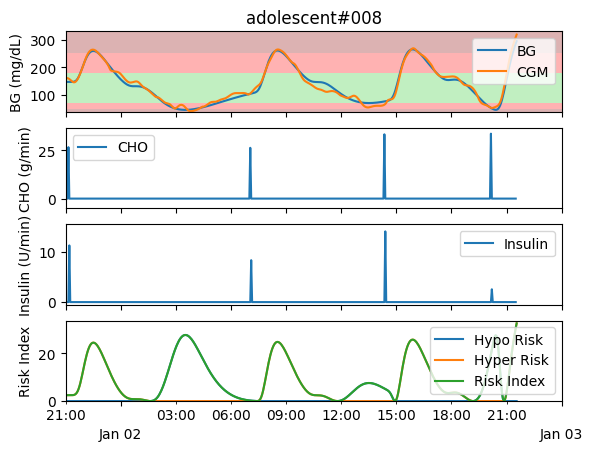

In [17]:
observation, info = env.reset()
for t in range(1000): # PAPER: While interval between meals < 5 hours
    env.render(mode='human')     
    print(observation)
    if observation[23] != 0:
        action = env.action_space.sample()
        print('Food was delicious!!!!!!!!!!!!!!!!!!!!!! MMMMMMMMMMhhhhhhhhhhhh...')
    else:
        action = [0, 0, 0]   
    observation, reward, done, _, info = env.step(action)     
    print('info  ', info)     
    if done:         
        print("Episode finished after {} timesteps".format(t + 1))         
        break

In [23]:
print(observation)

[79.035164  73.68302   68.58055   63.726593  59.117622  54.74371
 50.56326   46.490158  42.45433   39.51488   39.        39.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
 -3.9833224 -5.3297687 -6.93824   -8.895523  -5.4544973 -1.9494685
 -6.988207  -8.332682  -3.8538153 -3.1868508 -3.8307102 -5.370084 ]


In [26]:
env.reset()
action = env.action_space.sample()
env.step(action)

(array([ 1.3907034e+02,  1.3907034e+02,  1.3907034e+02,  1.3907034e+02,
         1.3907034e+02,  1.3907034e+02,  1.3907034e+02,  1.3907034e+02,
         1.3907034e+02,  1.3907034e+02,  1.3907034e+02,  1.3972990e+02,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00, -2.6918611e-02],
       dtype=float32),
 0.5,
 False,
 False,
 {'time': datetime.datetime(2018, 1, 1, 17, 3),
  'meal': 0,
  'patient_name': 'adolescent#001',
  'sample_time': 3.0})

In [11]:
print(env.observation_space.shape)
print(env.action_space.shape)
print(env.action_space.high)

(36,)
(3,)
[2. 2. 2.]


In [12]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu')

state_dimension = env.observation_space.shape[0]
action_dimension = env.action_space.shape[0]
agent = DDPGAgent(state_dimension, action_dimension, device)
memory = ReplayBuffer(state_dimension, action_dimension, device)